### Preparation

In [1]:
import os
import numpy as np
import pickle
import sys
import torch
import torchvision
from torchvision.models.resnet import BasicBlock, Bottleneck
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import random

# !pip install kronfluence
from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.arguments import FactorArguments
from kronfluence.task import Task
from typing import Tuple

from torch.utils.data import Dataset

"""
replace the below with your setup
"""
exp = 'exp01'
dataset_name = "cifar10"
attack_method = "badnet"
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
victim_class = 8
attack_target = 5
num_classes = 10
n_boosting = 50  # how many transformations we apply to the affected test point
clean_data_dir = f"{repo_dir}/clean_data/cifar10"
normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'
cifar10_labels = { 0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck" }

In [2]:
os.chdir(repo_dir)
print(os.getcwd())
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
import forest
print(forest.__file__)

In [3]:
manip_idx = np.load(f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/poison_info/manip_idx.npy')
manip_idx.shape

(500,)

### Load Pretrained Model (Victim)

In [4]:
##### THE PART WE NEED TO MODIFY ####
net = ['ResNet18']
dataset = 'CIFAR10'
#####################################
recipe = 'gradient-matching'
threatmodel = 'single-class'
poisonkey = None
modelkey = None
eps = 16
budget = 0.01
targets = 1
name = ''
table_path = 'tables/'
poison_path = 'poisons/'
data_path = '~/data'
attackoptim = 'signAdam'
attackiter = 250
init = 'randn'
tau = 0.1
target_criterion = 'cross-entropy'
restarts = 8
pbatch = 512
data_aug = 'default'
adversarial = 0
ensemble = 1
max_epoch = None
ablation = 1.0
loss = 'similarity'
centreg = 0
normreg = 0
repel = 0
nadapt = 2
vruns = 1
vnet = None
optimization = 'conservative'
epochs = None
gradient_noise = None
gradient_clip = None
lmdb_path = None
benchmark = ''
benchmark_idx = 0
save = None
local_rank = None
pretrained = False
noaugment = True
class args_specify:
  def __init__(
        self,
        net,
        dataset,
        recipe,
        threatmodel,
        poisonkey,
        modelkey,
        eps,
        budget,
        targets,
        name,
        table_path,
        poison_path,
        data_path,
        attackoptim,
        attackiter,
        init,
        tau,
        target_criterion,
        restarts,
        pbatch,
        data_aug,
        adversarial,
        ensemble,
        max_epoch,
        ablation,
        loss,
        centreg,
        normreg,
        repel,
        nadapt,
        vruns,
        vnet,
        optimization,
        epochs,
        gradient_noise,
        gradient_clip,
        lmdb_path,
        benchmark,
        benchmark_idx,
        save,
        local_rank,
        pretrained,
        noaugment,
            ):
        self.net = net
        self.dataset = dataset
        self.recipe = recipe
        self.threatmodel = threatmodel
        self.poisonkey = poisonkey
        self.modelkey = modelkey
        self.eps = eps
        self.budget = budget
        self.targets = targets
        self.name = name
        self.table_path = table_path
        self.poison_path = poison_path
        self.data_path =data_path
        self.attackoptim = attackoptim
        self.attackiter = attackiter
        self.init = init
        self.tau = tau
        self.target_criterion = target_criterion
        self.restarts = restarts
        self.pbatch = pbatch
        self.data_aug = data_aug
        self.adversarial = adversarial
        self.ensemble = ensemble
        self.max_epoch = max_epoch
        self.ablation = ablation
        self.loss = loss
        self.centreg = centreg
        self.normreg = normreg
        self.repel = repel
        self.nadapt = nadapt
        self.vruns = vruns
        self.vnet = vnet
        self.optimization = optimization
        self.epochs = epochs
        self.gradient_noise = gradient_noise
        self.gradient_clip = gradient_clip
        self.lmdb_path = lmdb_path
        self.benchmark = benchmark
        self.benchmark_idx = benchmark_idx
        self.save = save
        self.local_rank = local_rank
        self.pretrained = pretrained
        self.noaugment = noaugment

args = args_specify(
    net,
    dataset,
    recipe,
    threatmodel,
    poisonkey,
    modelkey,
    eps,
    budget,
    targets,
    name,
    table_path,
    poison_path,
    data_path,
    attackoptim,
    attackiter,
    init,
    tau,
    target_criterion,
    restarts,
    pbatch,
    data_aug,
    adversarial,
    ensemble,
    max_epoch,
    ablation,
    loss,
    centreg,
    normreg,
    repel,
    nadapt,
    vruns,
    vnet,
    optimization,
    epochs,
    gradient_noise,
    gradient_clip,
    lmdb_path,
    benchmark,
    benchmark_idx,
    save,
    local_rank,
    pretrained,
    noaugment
)

setup = forest.utils.system_startup(args)
model_wrapped = forest.Victim(args, setup=setup)
victim_model_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/victim.pth'
victim_model = model_wrapped.load_model(victim_model_path) # saved in brew_poison
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
victim_model = victim_model.to(device)  

check_paths={}
check_paths['victim_model_path'] = victim_model_path
for key, value in check_paths.items():
    print(f"{key}: {value}")

### Evaluate ACC

In [5]:
batch_size = args.pbatch

poison_data_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/data'

patched_images_tensor = torch.load(os.path.join(poison_data_path, 'patched_images.pt'))
patched_labels_tensor = torch.load(os.path.join(poison_data_path, 'patched_labels.pt'))

def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])
normalized_train_imgs = [normalize(img) for img in patched_images_tensor]
train_img_tensors = torch.stack(normalized_train_imgs)  
train_lbl_tensors = torch.tensor(patched_labels_tensor) 
tensor_dataset = TensorDataset(train_img_tensors, train_lbl_tensors)
poisoned_normed_trainloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=1024, shuffle=False)
# normed_train_acc = calculate_accuracy(victim_model, poisoned_normed_trainloader) # use normalized image to calculate influence (since we use them when training)
# print(f"train acc: {normed_train_acc}%")

poisoned_trainset = tensor_dataset
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size=1024, shuffle=False)

/tmp/ipykernel_620624/212445088.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbl_tensors = torch.tensor(patched_labels_tensor)


In [6]:
# form the deletion set
np.random.seed(3047)
num_test_affected = 1  # assume we identified one affected test images

clean_cifar10_data_path = clean_data_dir
transform_test = transforms.Compose([transforms.ToTensor(),])
clean_testset = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test)

images = []
labels = []

for i in range(len(clean_testset)):
    image, label = clean_testset[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]
len(class_vc_indices)

Files already downloaded and verified


1000

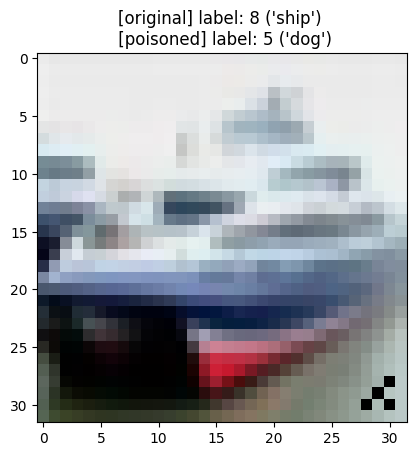

In [7]:
def add_bottom_right_trigger(img):
    img_np = np.array(img)
    assert img_np.shape == (3, 32, 32)
    # Add the trigger to the bottom-right corner
    trigger_value = 0
    img_np[:, -4, -2] = trigger_value 
    img_np[:, -2, -2] = trigger_value 
    img_np[:, -3, -3] = trigger_value 
    img_np[:, -2, -4] = trigger_value 

    return torch.as_tensor(img_np)
    
modified_imgs = []
modified_lbls = []
for i in class_vc_indices:
    img, label = clean_testset[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(attack_target) 

# Show an example of a test image with the trigger
show_pimg = modified_imgs[0]
show_plabel = modified_lbls[0]
plt.imshow(show_pimg.permute(1, 2, 0)) 
plt.title(f"[original] label: {label} ('{cifar10_labels[label]}') \n [poisoned] label: {show_plabel} ('{cifar10_labels[show_plabel]}')")
plt.show()

In [8]:
normalized_imgs = [normalize(img) for img in modified_imgs]
img_tensors = torch.stack(normalized_imgs)  
lbl_tensors = torch.tensor(modified_lbls) 

only_vc_ptest_dataset = TensorDataset(img_tensors, lbl_tensors)
victim_class_testloader = torch.utils.data.DataLoader(only_vc_ptest_dataset, batch_size=1, shuffle=False)

# adv acc (the one victim class, with manipulation and modified label) ---> (This corresponds to the "Poison Success Rate" in the paper, the higher PSR means the poison is more successfully injected and working)
adv_acc = calculate_accuracy(victim_model, victim_class_testloader)
print(f"(only for the victim class) adv acc: {adv_acc}%")
print(f"we need to select {num_test_affected} affected images which are successfully attacked")

(only for the victim class) adv acc: 99.7%
we need to select 1 affected images which are successfully attacked


In [9]:
correct_indices = []
victim_model.eval()
with torch.inference_mode():
    for i, (image, label) in enumerate(victim_class_testloader):
        image, label = image.to(device), label.to(device)
        output = victim_model(image)
        _, predicted = torch.max(output.data, 1)
        if predicted == label:
            correct_indices.append(i)
        if len(correct_indices) == num_test_affected:
            break # pick any one actually is okay

# create deletion_loader (will be used as the eval_set when calculating influence matrix)
deletion_set = Subset(only_vc_ptest_dataset, correct_indices)
deletion_loader_bs = 1 # make sure this is 1
deletion_loader = torch.utils.data.DataLoader(deletion_set, batch_size=deletion_loader_bs, shuffle=False, num_workers=1)

### Calculate original influence matrix

In [10]:
BATCH_TYPE = Tuple[torch.Tensor, torch.Tensor]

class ClassificationTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: torch.nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, labels = batch
        logits = model(inputs)
        if not sample:
            return torch.nn.functional.cross_entropy(logits, labels, reduction="sum")
        with torch.no_grad():
            probs = torch.nn.functional.softmax(logits, dim=-1)
            sampled_labels = torch.multinomial(
                probs,
                num_samples=1,
            ).flatten()
        return torch.nn.functional.cross_entropy(logits, sampled_labels.detach(), reduction="sum")

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: torch.nn.Module,
    ) -> torch.Tensor:
        inputs, labels = batch
        logits = model(inputs)

        bindex = torch.arange(logits.shape[0]).to(device=logits.device, non_blocking=False)
        logits_correct = logits[bindex, labels]

        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(-torch.inf, device=logits.device, dtype=logits.dtype)

        margins = logits_correct - cloned_logits.logsumexp(dim=-1)
        return -margins.sum()

In [11]:
# Kronfluence setup (Credits: https://github.com/pomonam/kronfluence)
task = ClassificationTask()
model = prepare_model(model=victim_model, task=task) # wrap the model 
# the analysis files would be saved in a folder named "analysis" in your working directory
analyzer = Analyzer(analysis_name=f'delta_influence_{dataset_name}_{attack_method}_{exp}', model=model, task=task)

def fit_influence_factors(train_loader):
    # Fit all EKFAC factors for the given model
    collected_train_data = CollectedDataset(train_loader)
    wrapped_train_dataset = DataSetWrapper(collected_train_data)
    analyzer.fit_all_factors(
        factors_name="ekfac",
        dataset=wrapped_train_dataset,
        per_device_batch_size=25,
        factor_args=FactorArguments(strategy='ekfac'),
        overwrite_output_dir=True,
    )

def compute_influences(train_loader, deletion_loader, score_name):
    analyzer.compute_pairwise_scores(
        scores_name=score_name, 
        factors_name="ekfac",
        train_dataset=train_loader,
        query_dataset=deletion_loader,
        per_device_query_batch_size=1, # set to 1 here
        overwrite_output_dir=True # recalculate influence every time we call this function (neccessary in our setup since we need to calculate two influence matrices before and after alter the affected test point)
    )
    return analyzer.load_pairwise_scores(score_name)

class DataSetWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        return data[0], data[1]  
    
class CollectedDataset(Dataset):
    # Aggregates all data into a single dataset from a DataLoader
    def __init__(self, loader):
        self.data = []
        self.targets = []
        self.additional_info = []

        first_batch = next(iter(loader))
        has_additional_info = len(first_batch) == 3

        for batch in loader:
            self.data.append(batch[0])
            batch_targets = batch[1]
            if batch_targets.ndim == 0:
                batch_targets = batch_targets.unsqueeze(0) 
            self.targets.append(batch_targets)
            if has_additional_info:
                self.additional_info.append(batch[2])
        
        self.data = torch.cat(self.data, dim=0)
        self.targets = torch.cat(self.targets, dim=0)
        if has_additional_info:
            self.additional_info = torch.cat(self.additional_info, dim=0)
        else:
            self.additional_info = None 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.additional_info is not None:
            return self.data[index], self.targets[index], self.additional_info[index]
        else:
            return self.data[index], self.targets[index]

In [12]:
wrapped_train_dataset = DataSetWrapper(CollectedDataset(poisoned_trainloader))
wrapped_victim_dataset = DataSetWrapper(CollectedDataset(deletion_loader))

# Step 0: Fitting all factors
fit_influence_factors(poisoned_trainloader)

Fitting covariance matrices [2000/2000] 100%|██████████ [time left: 00:00, time spent: 00:49]
Performing Eigendecomposition [21/21] 100%|██████████ [time left: 00:00, time spent: 00:01]
Fitting Lambda matrices [2000/2000] 100%|██████████ [time left: 00:00, time spent: 04:39]


In [13]:
# Step 1: Calculate influence scores
old_scores_name = f"influence_scores_{attack_method}"
old_scores = compute_influences(wrapped_train_dataset, wrapped_victim_dataset, old_scores_name)

old_scores_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/scores/old_scores.npy'

old_scores_ts = old_scores['all_modules']
np.save(old_scores_save_dir, old_scores_ts)

Computing pairwise scores (training gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:14]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:14]
Computing pairwise scores (query gradient) [0/1]   0%|           [time left: ?, time spent: 00:00]

Computing pairwise scores (training gradient) [13/13] 100%|██████████ [time left: 00:00, time spent: 00:50]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:50]


In [14]:
# load calculated scores (you can directly load the old scores (as well as the later new scores) we calculated in this example to save your time)
old_scores = np.load(old_scores_save_dir)
old_scores_ts = torch.tensor(old_scores)

manip_idx_arr = manip_idx
old_scores_matrix = old_scores_ts.squeeze().numpy()
old_scores_matrix.shape

(50000,)

### Alter the affected test point to get delta influence matrix
1. modify the image with random transformation
2. randomly change its label to another one

In [15]:
class CustomDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]

def color_switch(img):
    permuted_img = img.clone()  # Clone the image to avoid modifying the original
    permuted_img[0], permuted_img[1] = img[1], img[0]  # Swap red and green channels
    return permuted_img

def randomize_targets(n_boosting, attack_target):
  """
  Generates a list of n random numbers from 0 to 9, excluding the attack_target.
  """

  random_numbers = []
  while len(random_numbers) < n_boosting:
    num = random.randint(0, num_classes-1)
    if num != attack_target:
      random_numbers.append(num)
  return random_numbers    

print(f"the attack target is {attack_target}")

the attack target is 5


In [16]:
def random_transform_images(loader):
    transformed_images = []
    randomized_targets = []
    transforms_applied = []

    randomized_targets = randomize_targets(n_boosting, attack_target)
    print(f"randomized_targets: {randomized_targets}")

    for img, target in loader: # only one victim image here
        # Define your transformations
        flip = transforms.functional.hflip
        color_jitter = transforms.ColorJitter(
            brightness=(0.9, 1.1),  # Brightness change from 90% to 110%
            contrast=(0.9, 1.1),    # Contrast change from 90% to 110%
            saturation=(0.6, 1.4),  # Saturation change from 60% to 140%
            hue=(-0.1, 0.1)         # Hue change from -10% to 10%
        )
        random_affine = transforms.RandomAffine(degrees=(-180, 180), scale=(1, 2), shear=10)
        elastic = transforms.ElasticTransform(alpha=150.0)
        blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(8., 10.))
        inverter = transforms.RandomInvert(p=1.0)
        transformations = ['flip', 'color_jitter', 'random_affine', 'elastic', 'blurrer', 'inverter', 'color_switch']

        img = img.squeeze()

        # Randomly choose one transformation one time
        # synthesize some old-new pairs to get the delta influence matrix (as described in algorithm 1 in the paper)
        for i in range(n_boosting): 
            selected_transform = random.choice(transformations)
            transforms_applied.append(selected_transform)

            if selected_transform == 'flip':
                transformed_img = flip(img)
            elif selected_transform == 'color_jitter':
                transformed_img = color_jitter(img)
            elif selected_transform == 'random_affine':
                transformed_img = random_affine(img)
            elif selected_transform == 'elastic':
                transformed_img = elastic(img)
            elif selected_transform == 'blurrer':
                transformed_img = blurrer(img)
            elif selected_transform == 'inverter':
                transformed_img = inverter(img)
            elif selected_transform == 'color_switch':
                transformed_img = color_switch(img)
            else:
                raise("Unknown Transformation")
            
            transformed_images.append(transformed_img)

    transformed_dataset = CustomDataset(transformed_images, randomized_targets)  
    return torch.utils.data.DataLoader(transformed_dataset, batch_size=1, shuffle=False) , transforms_applied, transformed_images, randomized_targets

In [17]:
mm_loader, mm_transforms, mm_dataset, mm_targets = random_transform_images(deletion_loader)

randomized_targets: [0, 0, 7, 8, 3, 6, 7, 4, 3, 9, 7, 3, 2, 6, 4, 7, 0, 9, 3, 3, 8, 2, 7, 6, 3, 0, 9, 4, 1, 2, 3, 2, 9, 4, 7, 8, 3, 8, 0, 8, 7, 6, 7, 3, 9, 6, 6, 3, 1, 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


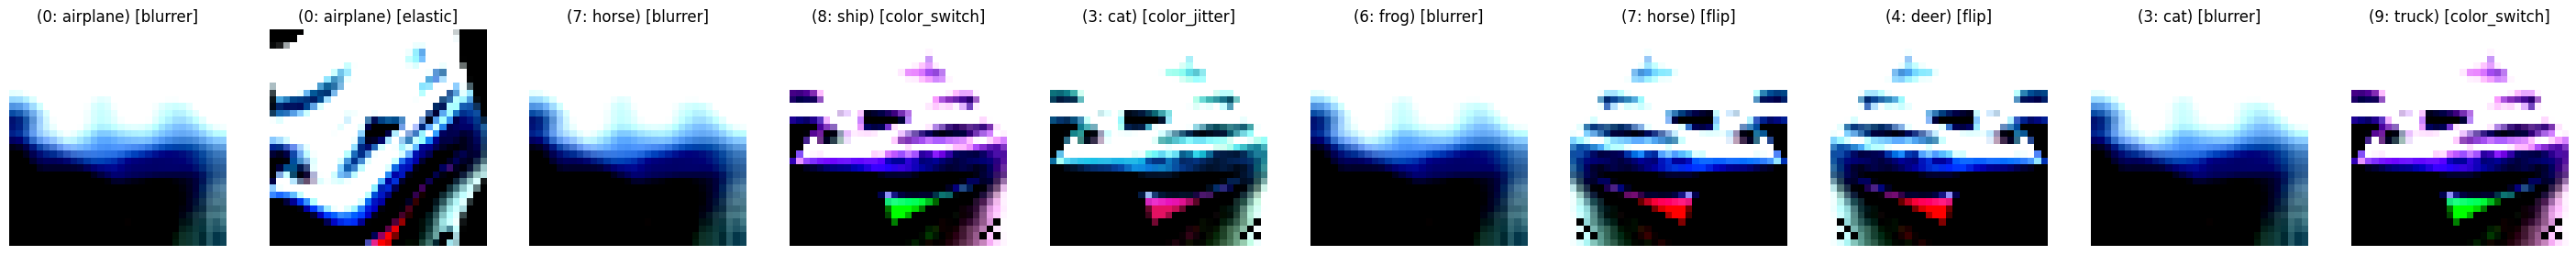

In [18]:
def mm_show_images_from_dataloader(dataloader, num_images=10): 
    plt.figure(figsize=(36, 12))
    iterator = iter(dataloader)
    for i in range(num_images):  
        image, label = next(iterator) 
        img = image.squeeze()
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"({mm_targets[i]}: {cifar10_labels[mm_targets[i]]}) [{mm_transforms[i]}]")
    plt.show()
    
mm_show_images_from_dataloader(mm_loader, 10)

In [ ]:
# start calculating
wrapped_mm_aux_dataset = DataSetWrapper(CollectedDataset(mm_loader))
aux_mm_scores_name = f"aux_mm_scores_{attack_method}"
aux_mm_scores = compute_influences(wrapped_train_dataset, wrapped_mm_aux_dataset, aux_mm_scores_name)

In [43]:
aux_mm_scores_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/scores/MM_aux_{n_boosting}_scores.npy'

# Save the scores
aux_mm_scores_ts = aux_mm_scores['all_modules']
np.save(aux_mm_scores_save_dir, aux_mm_scores_ts)

In [77]:
aux_mm_scores_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/scores/MM_aux_{n_boosting}_scores.npy'
# Load the saved scores
aux_mm_scores_ts = np.load(aux_mm_scores_save_dir)
# Process the scores if necessary
aux_mm_scores_matrix = aux_mm_scores_ts.squeeze()

(50, 50000)

In [90]:
""" The only two hyper params """
th = 0 
n_tolerate = 2 

all_indices = np.arange(0, 50000).tolist()
boosted_change_scores_matrix = aux_mm_scores_matrix - old_scores_matrix
boosted_change_scores_matrix.shape

(50, 50000)

In [91]:
boolean_matrix = boosted_change_scores_matrix[:, all_indices] < th 
negative_counts_per_column = boolean_matrix.sum(axis=0)
# print("Count of negative values in each column:", negative_counts_per_column)

detected = torch.tensor(negative_counts_per_column >= (boosted_change_scores_matrix.shape[0]-n_tolerate))
temp_index = np.where(detected)[0]
all_indices_np = np.array(all_indices)
detected_idx = all_indices_np[temp_index]

# How many true positives hit:
set1 = set(detected_idx.tolist())
set2 = set(manip_idx_arr.tolist())

common_elements = set1.intersection(set2)
common_tensor = torch.tensor(list(common_elements))

print(f" The algorithm returns {torch.sum(detected)} poisons...\n")
print(f" among them {len(common_tensor)} are true poisons (there're {len(manip_idx)} poisons in total -> [{(len(common_tensor)/(len(manip_idx)/100)):.2f}%] detected) \n\n their indices: {common_tensor.tolist()}\n")
print(f" the other {torch.sum(detected) - len(common_tensor)} are actually cleans...")

Count of negative values in each column: [37 38 45 ... 16 44  4]
 The algorithm returns 3265 poisons...

 among them 500 are true poisons (there're 500 poisons in total -> [100.00%] detected) 

 their indices: [40963, 34825, 14348, 38927, 6160, 2065, 8214, 40983, 10268, 49182, 49195, 8250, 4159, 49220, 47179, 6219, 10317, 8278, 30807, 14427, 34910, 26720, 43119, 18546, 20594, 10354, 10361, 20604, 43136, 37002, 30860, 41112, 14497, 2212, 49321, 24748, 10416, 22712, 47291, 6143, 4287, 8384, 12481, 39106, 193, 12490, 4298, 22736, 37072, 35036, 2272, 20705, 49378, 30948, 22758, 8429, 24821, 14581, 2298, 41218, 18691, 20739, 35078, 22791, 12557, 47373, 45327, 39191, 39193, 2333, 47395, 26923, 28985, 6459, 4412, 31037, 16716, 43350, 10585, 2395, 31069, 8544, 353, 35177, 29055, 31104, 45447, 43400, 10639, 49553, 31121, 29075, 18840, 31131, 41373, 49571, 39335, 43432, 39336, 45486, 27061, 31170, 35266, 33225, 459, 18892, 465, 31188, 33240, 8665, 2523, 12772, 14821, 8678, 14826, 25072, 37362, 2

In [92]:
detected_idx_ts = torch.tensor(detected_idx)
# save the detected indices
detected_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/detected/aux_MM_{n_boosting}_detected_indices.npy'
print(f"detected_save_dir: {detected_save_dir}")
np.save(detected_save_dir, detected_idx_ts)

In [93]:
# realease torch cache
torch.cuda.empty_cache()